In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 66.1MB 64kB/s 


In [ ]:
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
import csv
train = pd.read_csv('Train.csv')
train_copy = train.copy()
test = pd.read_csv('Test.csv')
test_copy = test.copy()
ss = pd.read_csv('SS.csv')
ss_copy = ss.copy()


In [ ]:
train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [ ]:
ss.head(3)

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N


In [ ]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [ ]:
ID_COL, TARGET_COL = 'Loan_ID', 'Loan_Status'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

cat_cols = ['Gender','Married','Education','Self_Employed','Property_Area']

num_cols = [c for c in features if c not in cat_cols]

In [ ]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 614 samples and 13 variables

Test contains 367 samples and 12 variables

The dataset contains 11 features


0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

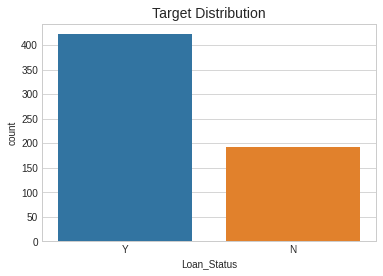

In [ ]:
train['Loan_Status'].map({'N': 0, 'Y': 1})
_ = sns.countplot(train[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Credit_History       8.1
Self_Employed        5.2
LoanAmount           3.6
Dependents           2.4
Loan_Amount_Term     2.3
Gender               2.1
Married              0.5
Loan_Status          0.0
Property_Area        0.0
CoapplicantIncome    0.0
ApplicantIncome      0.0
Education            0.0
Loan_ID              0.0
dtype: float64

In [ ]:
train.nunique()

Loan_ID              614
Gender               2  
Married              2  
Dependents           4  
Education            2  
Self_Employed        2  
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term     10 
Credit_History       2  
Property_Area        3  
Loan_Status          2  
dtype: int64

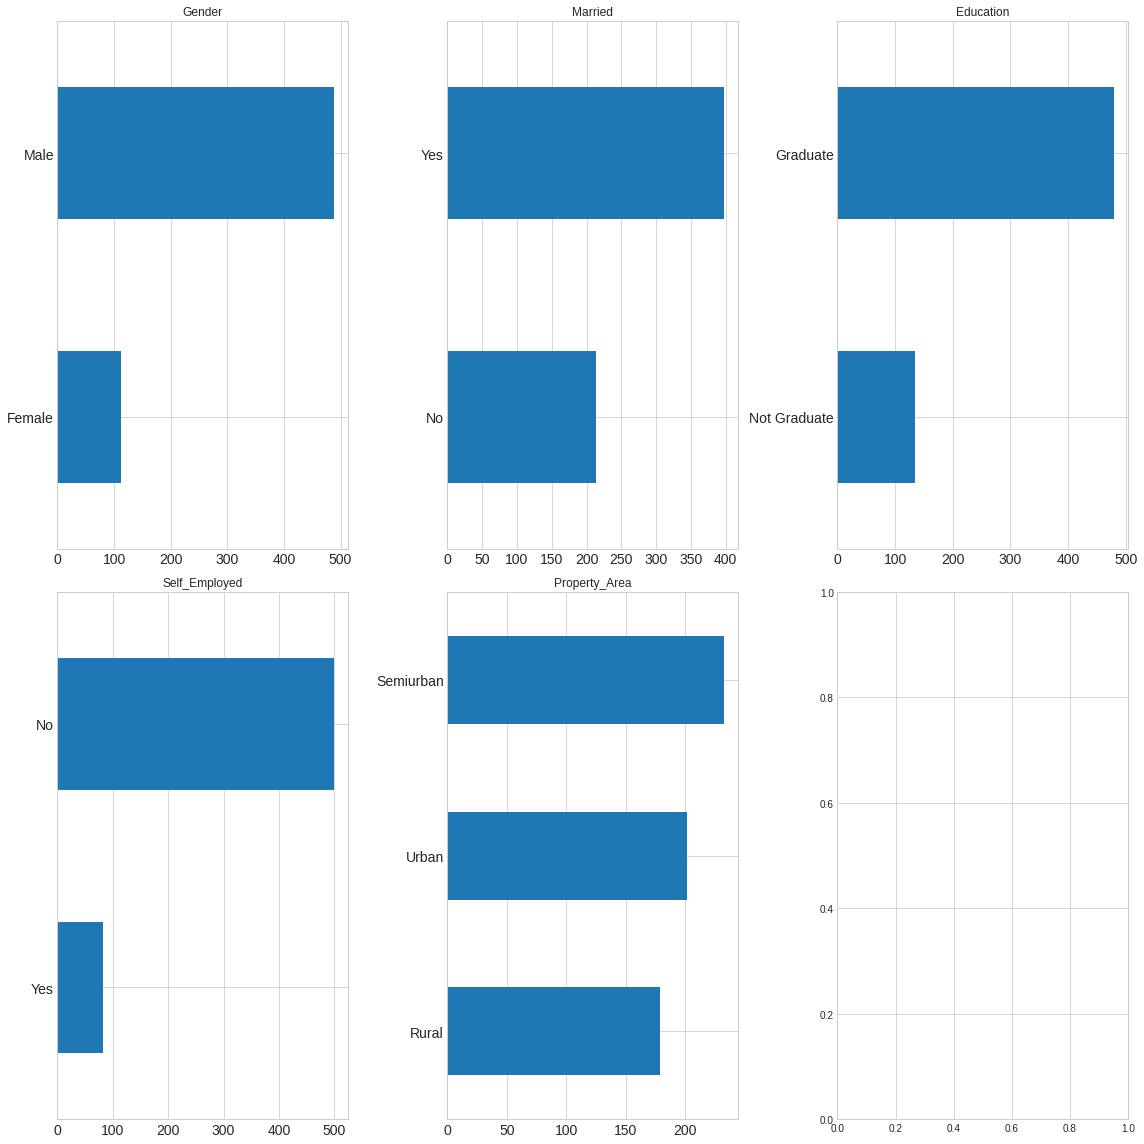

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

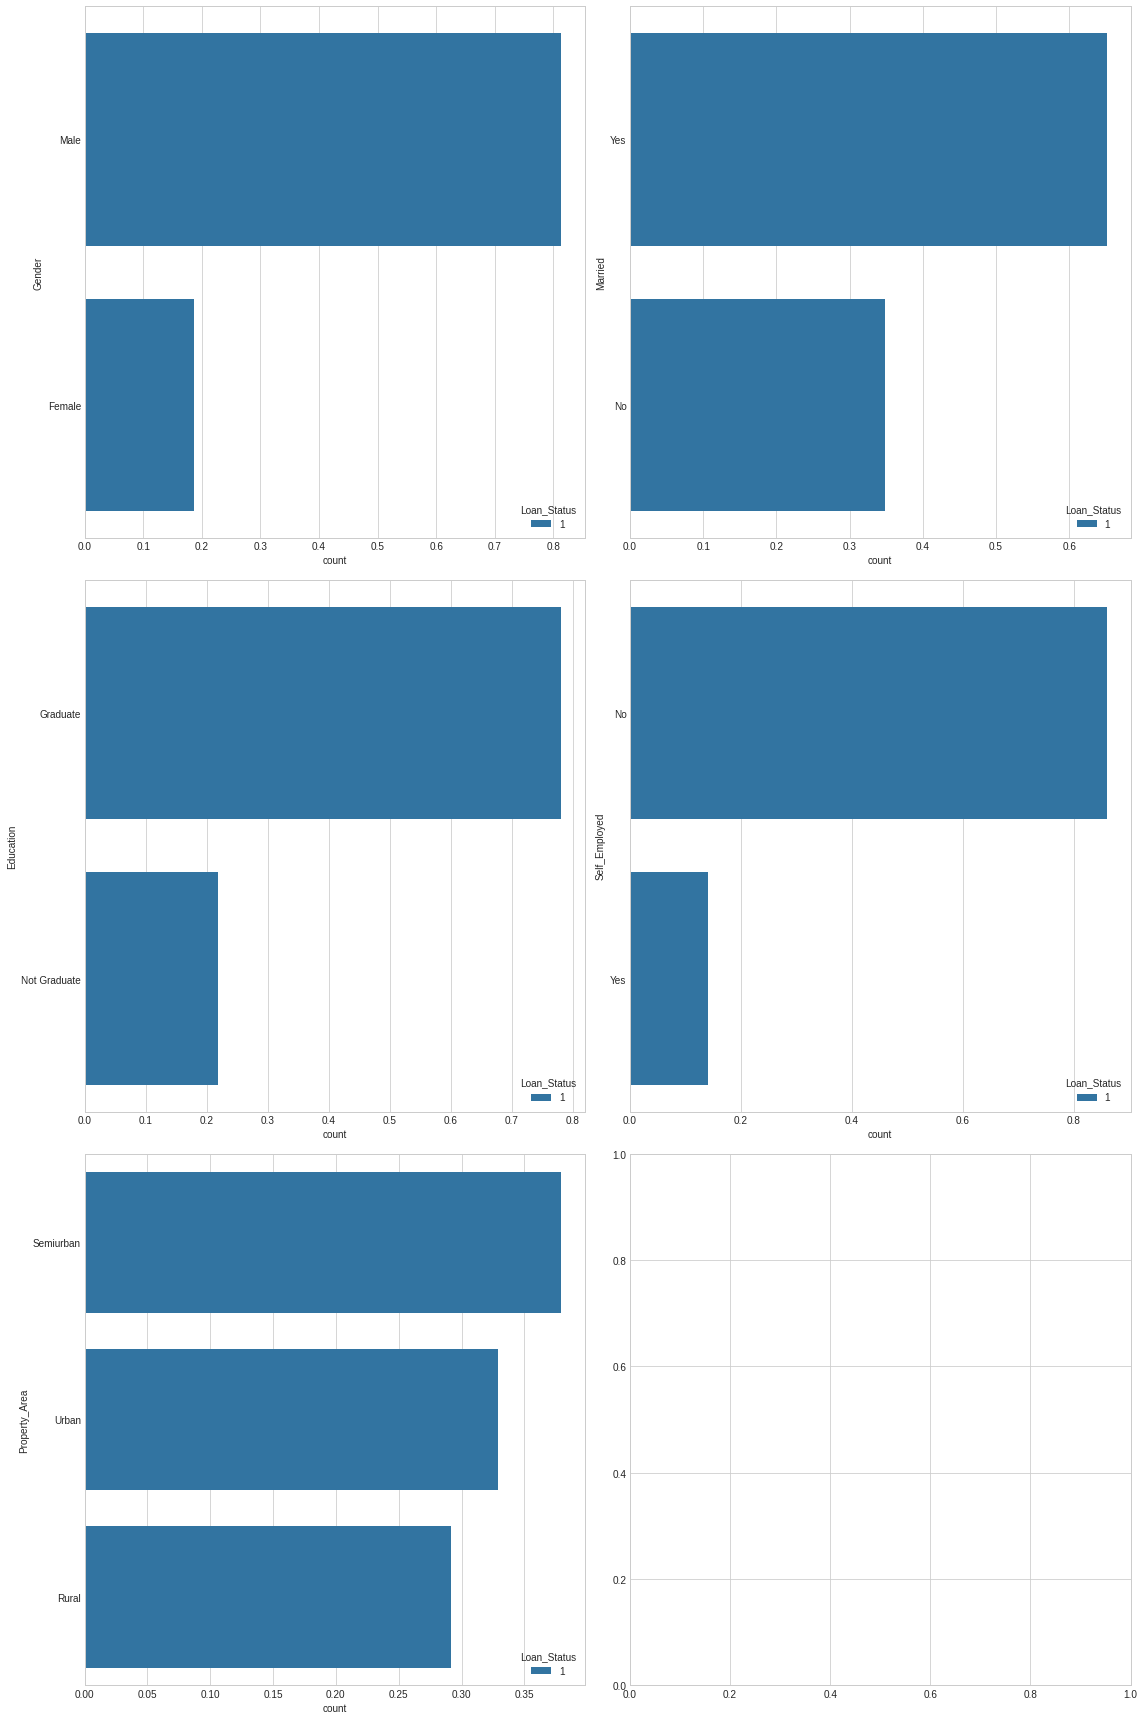

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

<Figure size 1008x576 with 0 Axes>

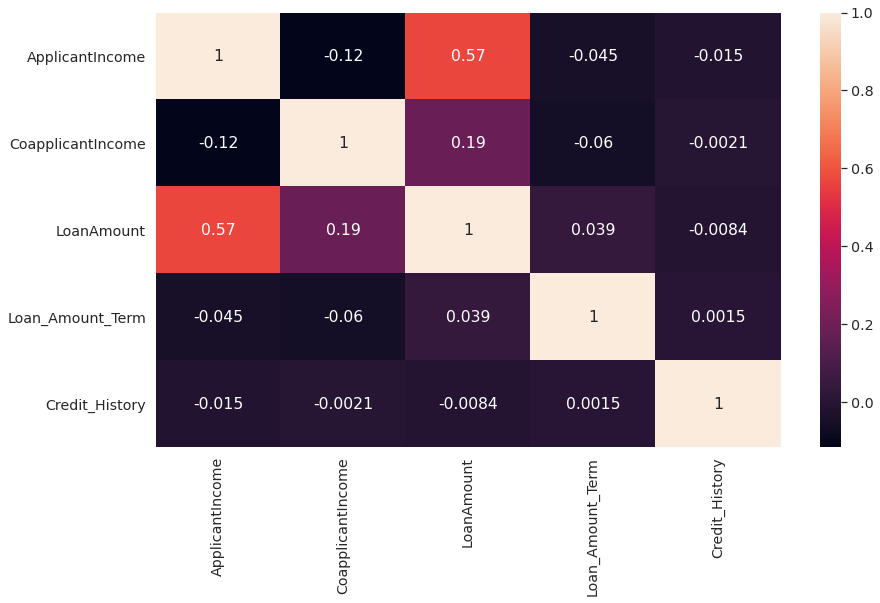

In [ ]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols].corr(), annot=True)

In [ ]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

In [ ]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(981, 13)

In [ ]:
df = pd.get_dummies(df, columns = cat_cols)

In [ ]:
df

,Loan_ID,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,0,5849,0.0,NaN,360.0,1.0,Y,0,1,1,0,1,0,1,0,0,0,1
1,LP001003,1,4583,1508.0,128.0,360.0,1.0,N,0,1,0,1,1,0,1,0,1,0,0
2,LP001005,0,3000,0.0,66.0,360.0,1.0,Y,0,1,0,1,1,0,0,1,0,0,1
3,LP001006,0,2583,2358.0,120.0,360.0,1.0,Y,0,1,0,1,0,1,1,0,0,0,1
4,LP001008,0,6000,0.0,141.0,360.0,1.0,Y,0,1,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,LP002971,3+,4009,1777.0,113.0,360.0,1.0,NaN,0,1,0,1,0,1,0,1,0,0,1
977,LP002975,0,4158,709.0,115.0,360.0,1.0,NaN,0,1,0,1,1,0,1,0,0,0,1
978,LP002980,0,3250,1993.0,126.0,360.0,NaN,NaN,0,1,1,0,1,0,1,0,0,1,0
979,LP002986,0,5000,2393.0,158.0,360.0,1.0,NaN,0,1,0,1,1,0,1,0,1,0,0


In [ ]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

In [ ]:
df.replace('3+',3,inplace=True)

In [ ]:
df

,Loan_ID,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,0,5849,0.0,-999.0,360.0,1.0,Y,0,1,1,0,1,0,1,0,0,0,1
1,LP001003,1,4583,1508.0,128.0,360.0,1.0,N,0,1,0,1,1,0,1,0,1,0,0
2,LP001005,0,3000,0.0,66.0,360.0,1.0,Y,0,1,0,1,1,0,0,1,0,0,1
3,LP001006,0,2583,2358.0,120.0,360.0,1.0,Y,0,1,0,1,0,1,1,0,0,0,1
4,LP001008,0,6000,0.0,141.0,360.0,1.0,Y,0,1,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,LP002971,3,4009,1777.0,113.0,360.0,1.0,-999,0,1,0,1,0,1,0,1,0,0,1
977,LP002975,0,4158,709.0,115.0,360.0,1.0,-999,0,1,0,1,1,0,1,0,0,0,1
978,LP002980,0,3250,1993.0,126.0,360.0,-999.0,-999,0,1,1,0,1,0,1,0,0,1,0
979,LP002986,0,5000,2393.0,158.0,360.0,1.0,-999,0,1,0,1,1,0,1,0,1,0,0


In [ ]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [ ]:
len(features)

17

In [ ]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1, stratify = train_proc[TARGET_COL])

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

In [ ]:
X_test

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,5720,0.0,110.0,360.0,1.0,0,1,0,1,1,0,1,0,0,0,1
1,1,3076,1500.0,126.0,360.0,1.0,0,1,0,1,1,0,1,0,0,0,1
2,2,5000,1800.0,208.0,360.0,1.0,0,1,0,1,1,0,1,0,0,0,1
3,2,2340,2546.0,100.0,360.0,-999.0,0,1,0,1,1,0,1,0,0,0,1
4,0,3276,0.0,78.0,360.0,1.0,0,1,1,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,3,4009,1777.0,113.0,360.0,1.0,0,1,0,1,0,1,0,1,0,0,1
363,0,4158,709.0,115.0,360.0,1.0,0,1,0,1,1,0,1,0,0,0,1
364,0,3250,1993.0,126.0,360.0,-999.0,0,1,1,0,1,0,1,0,0,1,0
365,0,5000,2393.0,158.0,360.0,1.0,0,1,0,1,1,0,1,0,1,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
clf = LogisticRegression()
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

accuracy_score(y_val, preds_val)

0.6829268292682927

In [ ]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_logistic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
clf = DecisionTreeClassifier()
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)
accuracy_score(y_val, preds_val)

0.7073170731707317

In [ ]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_logistic.csv')

In [ ]:
?RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(random_state = 2,
                             max_depth= 15,
                             max_features= 0.65,
                             max_leaf_nodes=256,
                             min_samples_split=5)
                            
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

accuracy_score(y_val, preds_val)

0.8211382113821138

In [ ]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_trf1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
?LGBMClassifier

In [ ]:
clf = LGBMClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.9,
                     colsample_bytree=0.95,reg_alpha=2, nthread=4, scale_pos_weight=1, seed=27)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

accuracy_score(y_val, preds_val)

0.7967479674796748

In [ ]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_lg1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
clf = CatBoostClassifier(learning_rate=0.02,random_seed=123,n_estimators=400,colsample_bylevel=0.45,max_depth=6,verbose=50)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

accuracy_score(y_val, preds_val)

0:	learn: 0.6835452	total: 2.18ms	remaining: 872ms
50:	learn: 0.4669964	total: 99.4ms	remaining: 680ms
100:	learn: 0.4040351	total: 186ms	remaining: 549ms
150:	learn: 0.3640139	total: 274ms	remaining: 452ms
200:	learn: 0.3343990	total: 361ms	remaining: 358ms
250:	learn: 0.3040985	total: 450ms	remaining: 267ms
300:	learn: 0.2785481	total: 542ms	remaining: 178ms
350:	learn: 0.2563182	total: 633ms	remaining: 88.3ms
399:	learn: 0.2354442	total: 722ms	remaining: 0us


0.8292682926829268

In [ ]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_cat10.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
clf = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.9,
                     colsample_bytree=0.95,reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

accuracy_score(y_val, preds_val)

0.7967479674796748

In [ ]:
preds_test = clf.predict(X_test)
download_preds(preds_test, file_name='hacklive_x1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>